
# 0 : Real time analysis of wikipedia updates - 
This notebook is the first in a series showing the progression of a developer or data professional with developer skills moving from data exploration, modular application building to delivering consumable visualizations on Machine learnt analysis.

- Data exploration in pure python
- Data aggregation and filtering
- Data windowing
- Data data extraction.
- Image analyisis

We are exploring a publicly available and accessible streaming data source from Mediawiki.org. MediaWiki is a free and open source software wiki package written in PHP, originally for use on Wikipedia. The website maintained to promote this open source offering offers an accessible feed of changes to all of the pages and assets that make it up. People editing Media wiki pages are around the world, working in different languages

# Streaming data exploration

Data science projects commonly start with a data set with defined characteristcs. A data professional will explore the data. Assess it for completeness, quality and relevance to the project purpose.

For streaming data, the process is similar even though the actual data elements are constantly changing. This notebook show those first exploration steps to allow a data professional to understand the data they are presented with for analysis.

The specification of the mediawiki feed can be found here. https://wikitech.wikimedia.org/wiki/Event_Platform/EventStreams

The data is streamed using the Server-Sent Events (SSE) protocol. This is similar in some respects to Websockets, however SSE is one-way only and uses HTTP as the transport. 
The feed itself is available here. https://stream.wikimedia.org/v2/stream/recentchange

In this exploration phase we are using pure Python in a Jupyter notebook for this data exploration. In later steps the code we develop here will become the seed for our Streams application.

In [1]:
!pip install SSEClient

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from IPython.display import display, clear_output
from sseclient import SSEClient as EventSource
import time
import json
from statistics import mean
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

### Define functions and helpers to use for our exploration

In [3]:
"""This is the core function for tapping into the feed"""
def get_events(url="https://stream.wikimedia.org/v2/stream/recentchange"):
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource(url):
        """for each change record in this fetch"""
        if len(change.data):
            """if the change contains any data"""
            yield json.loads(change.data)
            """Return it as a json object"""
                 
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop

    ."""
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

@catchInterrupt
def sample_events(wait_between=5, interations=1):
    """fetch events from Wikipedia, display and repeat. 
    ..note:: 
        Helper to look at the raw feed, with this you can see all the fields retrned
    Args: 
        - wait_between : seconds to wait between samples
        - interations = number of interations, < 0 infinite
    """
    for evt in get_events():
        if interations == 0: break
        interations -= 1
        print(json.dumps(evt, indent=1, sort_keys=True))
        time.sleep(wait_between)
        clear_output(wait=True)

The cell below displays a subset of the fields that are available. Invoking 
the sample_events() will return the full complement of fields. 

In [4]:
@catchInterrupt
def table_events(chunk_size=10, column_keys=[], interations=10):
    """Display selected columns in in table, in chunk_size.
    Args::
        - column_keys : columns to display
        - chunk_size : number of columns to show at a time.
        - interations : number of times to loop, <=0 is infinite
    """
    while interations != 0:
        lst = []
        interations -= 1
        for evt in get_events():
            lst.append(evt)
            if len(lst) > chunk_size: break
        dList = pd.DataFrame(lst)
        print(dList[column_keys])
        clear_output(wait=True)
        
table_events(column_keys=["type", "bot", "user", "wiki", "title"])

          type    bot                      user          wiki  \
0         edit   True                   MsynBot  wikidatawiki   
1         edit   True                     Adamt        plwiki   
2         edit  False              Freshacconci        enwiki   
3         edit  False             213.60.17.153        glwiki   
4         edit  False  எஸ். பி. கிருஷ்ணமூர்த்தி        tawiki   
5         edit  False                 Đông Minh        viwiki   
6         edit  False                  Mahir256  wikidatawiki   
7         edit   True                 XabatuBot  wikidatawiki   
8          new   True        QuickStatementsBot  wikidatawiki   
9          new  False                Mateo K 01        hrwiki   
10  categorize   True                     Adamt        plwiki   

                                      title  
0                                  Q5416313  
1   Kategoria:Obiekty sakralne w Augustowie  
2                     User talk:Epanastasis  
3                            Robert

## Focus on type

The events are characterized with the possible values of: new, edit, catagorize and log. 
We'll drill down into event types arriving, showing the counts for a chunk of 20 events and averaging over
5 chunks. 


In [5]:
# Aggregate collections of rows

class chunking_average:
    """Aggregate field values"""
    def __init__(self, init_base, mean_elements=20):
        self.deques = {key:deque([0],maxlen=mean_elements) for key in init_base.keys()}

    def aggregate(self, chunk):
        for key in self.deques.keys():
            if self.deques[key] and chunk[key]: self.deques[key].append(chunk[key])
        return {key:mean(self.deques[key]) for key in self.deques.keys()}

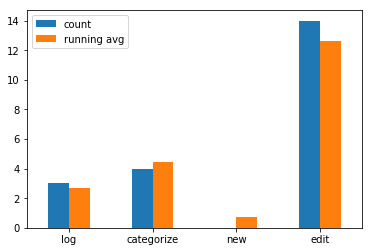

In [6]:
# tally the the types
#from collections import Counter

@catchInterrupt
def graph_type(events_window=20, average_windows=5, interations=5):
    """Display graph of page types arriving, windows and average windows worth. 
    
    Args:
        - events_window : number of updates within a window.
        - average_windows : number of windows average
    
    """
    interations += average_windows
    cnt = dict({"new":0, "edit":0, "categorize":0,"log":0})
    run_avg = chunking_average(cnt)
    try: 
        while interations != 0:
            interations -= 1
            for evt in get_events():
                if evt['type'] in cnt:
                    cnt[evt['type']] += 1
                    if sum(cnt.values()) > events_window: break
            avg = run_avg.aggregate(cnt)
            if average_windows <= 0:
                clear_output(wait=True)
                nam_list = [key for key in cnt.keys()]
                evt_list = [cnt[key] for key in nam_list]
                avg_list = [avg[key] for key in nam_list]
                df = pd.DataFrame({'count': evt_list, 'running avg': avg_list}, index=nam_list)
                df.plot.bar(rot=0)
                plt.show()
            else:
                print("Elements to stage ...{} ".format( average_windows))
                average_windows -= 1
            cnt = {key:0 for key in cnt}
    except (KeyboardInterrupt): pass
graph_type()

## Notebook wrapup

With this notebook we've accessed live wikipedia data, done redumentary calculations and graphed it.
Since all the components are in a notebook, data is only collected while the notebook is open which 
provides only limited insights what is happening. 

Collecting the data continiously is the next phase. In addition to the collecting we'll do some intial processing 
of the live data make it more consumable. 
